In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os,re,glob,cv2
import PIL
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from tensorflow import keras

In [ ]:
image_datas = glob.glob('/content/drive/MyDrive/CV/gooddataset/*/*.png')
categories = ["spring","summer","autumn","winter"] 
dic = {"spring":0,"summer":1,"autumn":2,"winter":3}

X = []
Y = []

for imagename in image_datas:
  image = Image.open(imagename)
  image = image.resize((128,128))
  image = np.array(image)
  X.append(image)
  print(image)
  label = imagename.split('/')[7].split('.')[0]
  label = dic[label]
  print(label)
  Y.append(label)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[[[145  97  84]
  [145  97  84]
  [145  97  84]
  ...
  [145  97  84]
  [145  97  84]
  [145  97  84]]

 [[145  97  84]
  [145  97  84]
  [145  97  84]
  ...
  [145  97  84]
  [145  97  84]
  [145  97  84]]

 [[145  97  84]
  [145  97  84]
  [145  97  84]
  ...
  [145  97  84]
  [145  97  84]
  [145  97  84]]

 ...

 [[145  97  84]
  [145  97  84]
  [145  97  84]
  ...
  [145  97  84]
  [145  97  84]
  [145  97  84]]

 [[145  97  84]
  [145  97  84]
  [145  97  84]
  ...
  [145  97  84]
  [145  97  84]
  [145  97  84]]

 [[145  97  84]
  [145  97  84]
  [145  97  84]
  ...
  [145  97  84]
  [145  97  84]
  [145  97  84]]]
3
[[[188 146 142]
  [188 146 142]
  [188 146 142]
  ...
  [188 146 142]
  [188 146 142]
  [188 146 142]]

 [[188 146 142]
  [188 146 142]
  [188 146 142]
  ...
  [188 146 142]
  [188 146 142]
  [188 146 142]]

 [[188 146 142]
  [188 146 142]
  [188 146 142]
  ...
  [188 146 142]
  [188 146 142]
  [188 146 142]]

 ...

 [[188 146 142

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(X,Y,test_size=0.2, shuffle=True, random_state=44)

train_labels = train_labels[...,tf.newaxis]
test_labels = test_labels[...,tf.newaxis]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((4272, 128, 128, 3), (4272, 1), (1069, 128, 128, 3), (1069, 1))

In [ ]:
# train data class별 image 수
unique, counts = np.unique(np.reshape(train_labels,(4272,)),axis=-1, return_counts=True)
dict(zip(unique,counts))

{0: 799, 1: 1618, 2: 1209, 3: 646}

In [ ]:
# test data class별 image 수
unique, counts = np.unique(np.reshape(test_labels,(1069,)),axis=-1, return_counts=True)
dict(zip(unique,counts))

{0: 214, 1: 404, 2: 295, 3: 156}

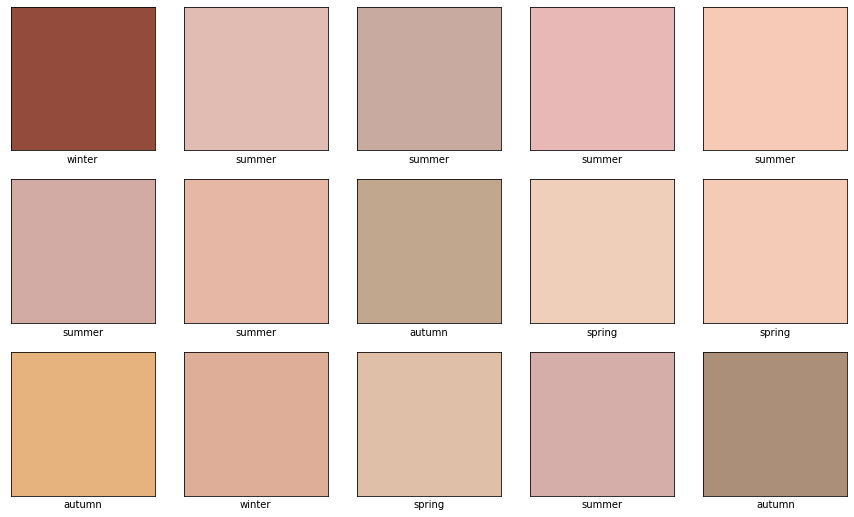

In [ ]:
# data 확인
plt.figure(figsize=(15,9))
for i in range(15):
  img_idx = np.random.randint(0,4272)
  plt.subplot(3,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[img_idx])
  plt.xlabel(categories[train_labels[img_idx][0]])

In [ ]:
# pixel값을 0~1사이 범위로 조정

train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [ ]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(4272, 128, 128, 3) (4272, 4)
(1069, 128, 128, 3) (1069, 4)


In [ ]:
# 하이퍼 파라미터
learning_rate = 0.0001
epochs = 15
batch_size = 32
category = 4

In [ ]:
# is_50 : True --> resnet_50
# is_plain :True --> no skip connection    
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50:
    # CNN 레이어
        for cnn_num in range(num_cnn):
            identity = x
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            if not is_plain:
                identity_channel = identity.shape.as_list()[-1]    

                if identity_channel != channel:
                    identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
                # skip connection
                x = keras.layers.Add()([x,identity])   
            else:
                pass
    else :
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)
        x = keras.layers.Conv2D(
            filters=channel * 4,
            kernel_size=(1,1),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_2_conv{cnn_num}'
        )(x)
        if not is_plain:
            identity_channel = identity.shape.as_list()[-1]    

            if identity_channel != channel:
                identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
            # skip connection
            x = keras.layers.Add()([x,identity])   
        else:
            pass
    #     Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x


In [ ]:
def build_resnet(input_shape=(128,128,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=4,is_50 = False, is_plain = False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 10
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [ ]:
# resnet 34
resnet_34 = build_resnet(is_50 = False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   832         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
from keras import optimizers
adam = keras.optimizers.Adam(learning_rate=0.0001)
resnet_34.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
history = resnet_34.fit(train_images,train_labels, 
                    batch_size=32, epochs=15,
                    validation_data = (test_images, test_labels))

Epoch 1/15
134/134 [==============================] - 966s 7s/step - loss: 0.8617 - accuracy: 0.7786 - val_loss: 1.2374 - val_accuracy: 0.4771
Epoch 2/15
134/134 [==============================] - 967s 7s/step - loss: 0.5771 - accuracy: 0.8256 - val_loss: 1.5203 - val_accuracy: 0.5061
Epoch 3/15
134/134 [==============================] - 968s 7s/step - loss: 0.4129 - accuracy: 0.8530 - val_loss: 0.5786 - val_accuracy: 0.8073
Epoch 4/15
134/134 [==============================] - 966s 7s/step - loss: 0.3478 - accuracy: 0.8659 - val_loss: 0.2930 - val_accuracy: 0.8756
Epoch 5/15
134/134 [==============================] - 967s 7s/step - loss: 0.3637 - accuracy: 0.8628 - val_loss: 0.4138 - val_accuracy: 0.8307
Epoch 6/15
134/134 [==============================] - 964s 7s/step - loss: 0.3590 - accuracy: 0.8542 - val_loss: 0.2189 - val_accuracy: 0.9102
Epoch 7/15
134/134 [==============================] - 960s 7s/step - loss: 0.4020 - accuracy: 0.8546 - val_loss: 0.2577 - val_accuracy: 0.8962

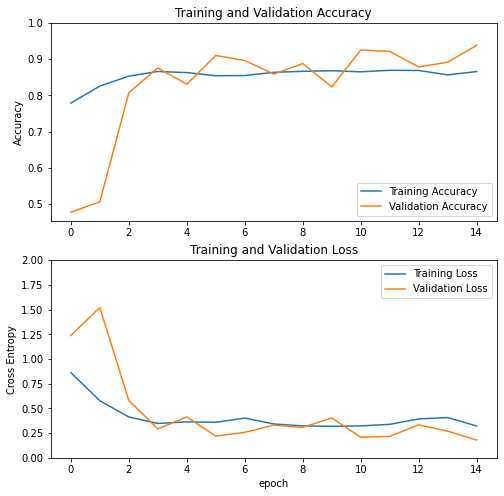

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if (predicted_label == true_label).all():
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(categories[predicted_label],
                                100*np.max(predictions_array),
                                categories[true_label]),
                                color=color)

In [ ]:
# 4개 그래프에 대한 예측 그래프로 표현
def plot_image(i, predictions_array, true_label, img): # 그래프로 표현하는 함수
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if (predicted_label == true_label).all():
     color = 'blue'
  else:
     color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(categories[predicted_label],
                                100*np.max(predictions_array),
                                categories[true_label]),
                                color=color)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(batch_size)

In [ ]:
def plot_value_array(i, predictions_array, true_label): #
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(range(4), categories, rotation=90)
  plt.yticks([])
  thisplot = plt.bar(range(4), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

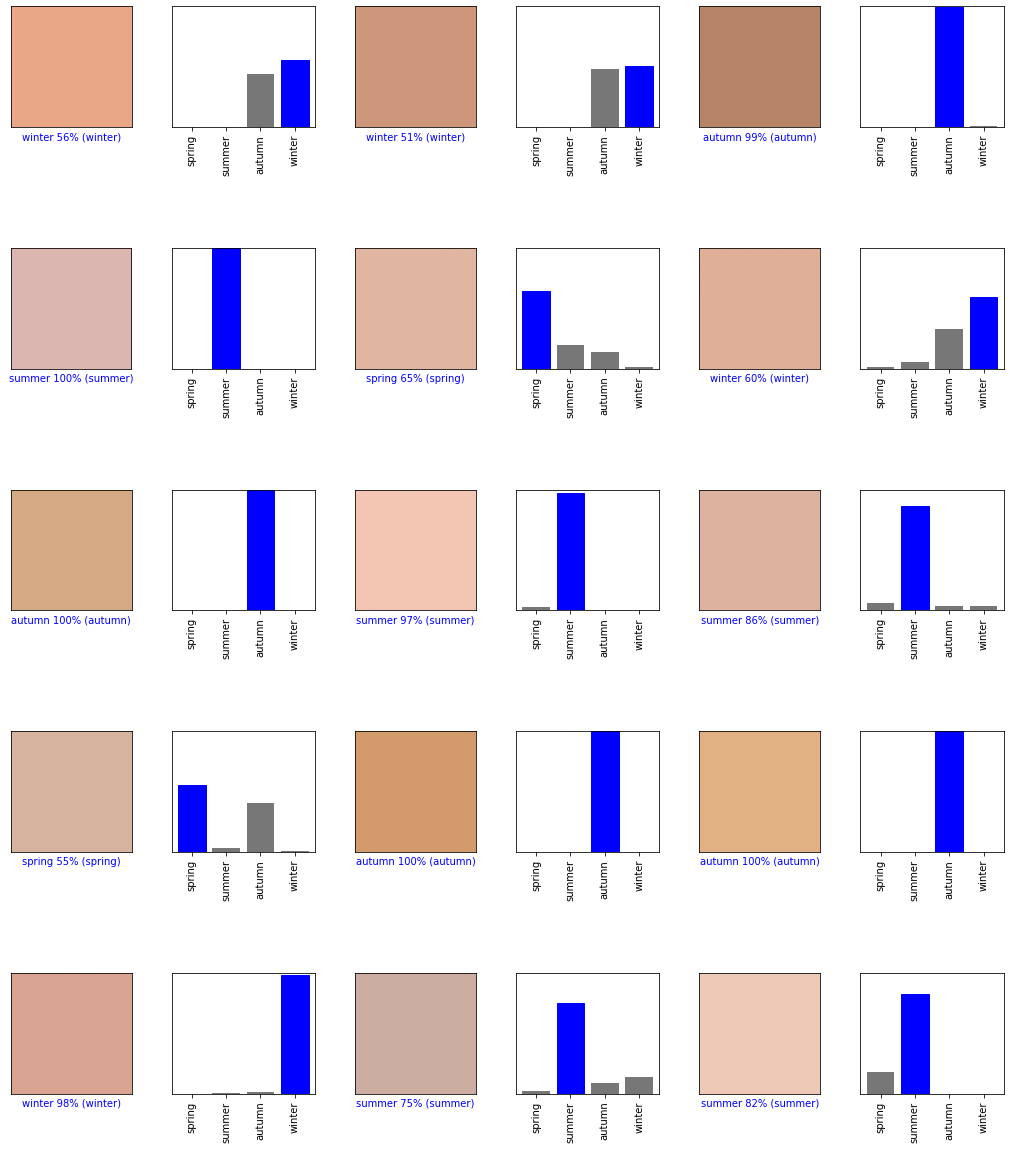

In [ ]:
# plt.subplot - 한개의 화면에 여러 그래프 나눠 그리기
# 파랑색 - 올바른 예측
# 빨강색 - 잘못된 예측
rnd_idx = np.random.randint(1,len(test_images)//batch_size)
img_cnt = 0  
for images, labels in test_dataset:
  img_cnt +=1
  if img_cnt != rnd_idx:
    continue
  predictions = resnet_34(images, training=False)
  num_rows = 5
  num_cols = 3
  num_images = num_rows*num_cols 
  labels = tf.argmax(labels, axis=-1)
  plt.figure(figsize=(3*2*num_cols, 4*num_rows))
  plt.subplots_adjust(hspace=1.0)
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions.numpy(), labels.numpy())
  break

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn
  img=keras.utils.load_img(path, target_size=(128, 128))

  x=keras.utils.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = resnet_34.predict(images, batch_size=batch_size)
  for i in range(0,4,1) :
    print(categories[i], "=", classes[0][i])
  print("예측한 결과 = " , categories[classes.argmax()])